# Demo GPU computation with CUDA
This demonstrates the use of low-level routines with a GPU.

### Generate fake data

In [1]:
from edge_analysis.io import simulated_awgn
import cupy as cp
import iqwaveform.cuda

# this takes a while the first time, so get it out of the way now
iqwaveform.cuda.build()

duration = 4
sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

with cp.cuda.Stream(non_blocking=False) as stream:
    raw_iq = simulated_awgn(duration, sample_rate_Hz, xp=cp)
    stream.synchronize()

### Analysis bandpass filter

In [2]:
from edge_analysis import channel_waveform
from scipy import signal

filter_params = dict(
    passband_ripple_dB=0.1,
    stopband_attenuation_dB=70,
    transition_bandwidth_Hz=250e3,
)

sos = channel_waveform.generate_iir_lpf(
    cutoff_Hz=analysis_bandwidth_Hz / 2, sample_rate_Hz=sample_rate_Hz, **filter_params
).astype('float32')

iq_cpu = signal.sosfilt(sos, raw_iq.get())

In [3]:
with cp.cuda.Stream(non_blocking=False) as stream:
    iq_gpu = cp.array(iq_cpu)
    stream.synchronize()
%timeit -n1 -r1 cp.fft.fft(iq_gpu[:2*1024]).get()

822 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [4]:
pvt = channel_waveform.power_time_series(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

In [5]:
%%timeit -n1 -r1

channel_waveform.power_time_series(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

102 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


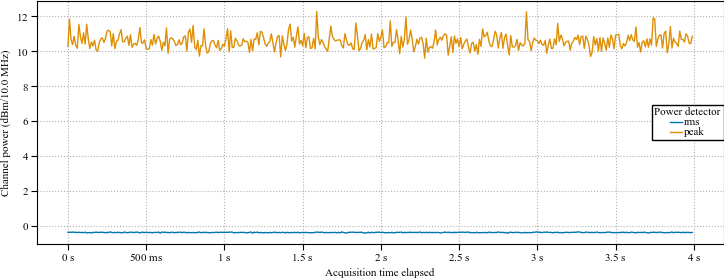

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [7]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
)

In [8]:
%%timeit -n1 -r1
print('GPU execution')
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

GPU execution
154 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


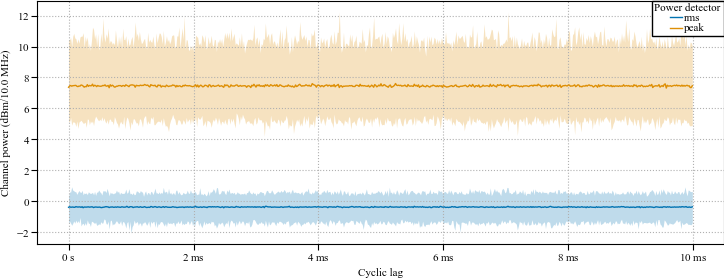

In [9]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [21]:
import importlib

channel_waveform = importlib.reload(channel_waveform)

frequency_resolution = 15e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles[::2],
)
spectrum

<xarray.DataArray 'persistence_spectrum' (baseband_frequency: 1024,
                                          persistence_statistic: 5)> Size: 41kB
array([[-108.42388632, -100.19247978,  -94.97259776,  -91.98659773,
         -87.60368072],
       [-108.4238315 , -100.21414585,  -94.95964619,  -91.93584632,
         -88.07391154],
       [-108.38550096, -100.21247255,  -94.99623576,  -91.92506283,
         -87.90335237],
       ...,
       [-108.42177589, -100.22269919,  -95.05474714,  -92.0155353 ,
         -88.13998961],
       [-108.38132711, -100.18789977,  -95.01871301,  -91.97586539,
         -88.15122483],
       [-108.37850565, -100.2042528 ,  -95.01289809,  -91.97672922,
         -87.05519591]])
Coordinates:
  * baseband_frequency     (baseband_frequency) float64 8kB -7.68e+06 ... 7.6...
  * persistence_statistic  (persistence_statistic) <U4 80B '0.1' '0.5' ... '1'
Attributes:
    label:               Power spectral density
    units:               dBm/56.554 kHz
    window:              flattop
    resolution_Hz:       15000.0
    fractional_overlap:  0
    noise_bandwidth_Hz:  56553.696711651435
    fft_size:            1024

In [23]:
%%timeit -n1 -r1
spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles[::2],
)

2.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


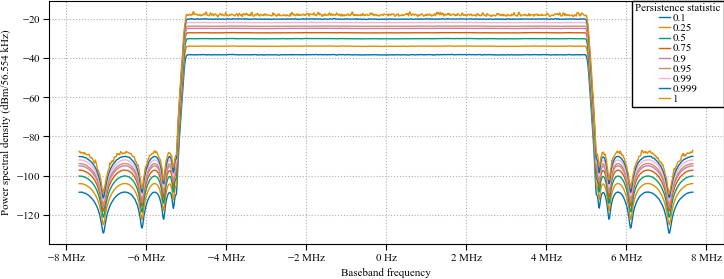

In [15]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [ ]:
apd_bins = dict(power_low=-40., power_high=15., power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq_gpu, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)

In [ ]:
%%timeit -n1 -r1

channel_waveform.amplitude_probability_distribution(
    iq_gpu, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)

In [ ]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, major_ticks=16, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)